In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 100,
})

import numpy as np
import torch

rng = np.random.default_rng()

# Loading data from mat file

In [2]:
from hexarena.utils import load_monkey_data
from hexarena.env import SimilarBoxForagingEnv

filename = 'store/monkey-data_040523/testSession2.mat'
block_idx = 6
print('Block {}'.format(block_idx))
block_data = load_monkey_data(filename, block_idx)

Block 6


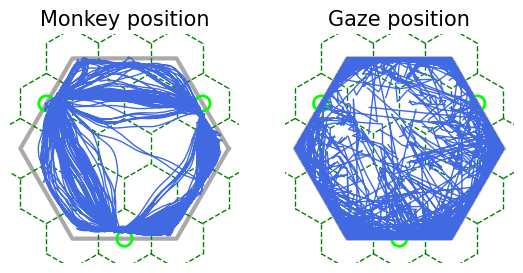

[35.0, 21.0, 15.0]


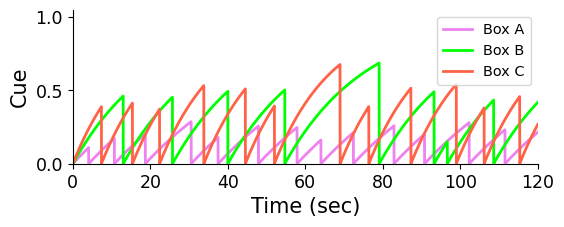

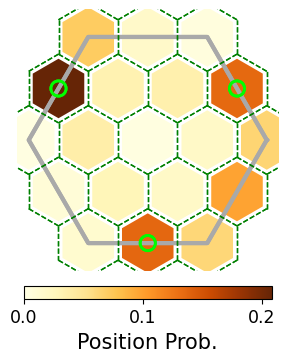

In [3]:
env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox', 'num_patches': 1, 'num_levels': 10, 'num_grades': 10,
    },
    boxes=[{'tau': tau, 'sigma': sigma} for tau, sigma in zip(block_data['taus'], block_data['kappas'])],
)

fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))

ax = axes[0]
env.arena.plot_mesh(ax)
pos_xyz = block_data['pos_xyz']/1860.5
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Monkey position', fontsize='medium')

ax = axes[1]
env.arena.plot_mesh(ax)
pos_xyz = block_data['gaze_xyz']/1860.5
ax.plot(pos_xyz[:, 0], pos_xyz[:, 1], color='royalblue', linewidth=1)
ax.set_title('Gaze position', fontsize='medium')

plt.show()

print([box.taus[0] for box in env.boxes])

fig, ax = plt.subplots(figsize=(6, 2))
colors = ['violet', 'lime', 'tomato']
for i, color in enumerate(colors):
    ax.plot(block_data['t'], block_data['cues'][:, i], color=color)
ax.legend(['Box A', 'Box B', 'Box C'], fontsize='x-small', loc='upper right')
ax.set_xlim([0, 120])
ax.set_xlabel('Time (sec)')
ax.set_ylim([0, 1.05])
ax.set_ylabel('Cue')

env_data = env.convert_experiment_data(block_data)
counts, _ = np.histogram(env_data['pos'], np.arange(-0.5, 0.5+env.arena.num_tiles))

fig, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_mesh(ax)
env.arena.plot_map(ax, counts/counts.sum(), clabel='Position Prob.')

plt.show()

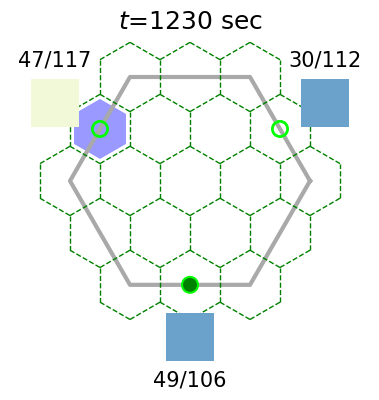

In [4]:
counts = np.zeros((len(env_data['pos']), 3, 2))
for t in range(len(env_data['push'])):
    if env_data['push'][t]:
        pos = env_data['pos'][t+1]
        if pos in env.arena.boxes:
            b_idx = env.arena.boxes.index(pos)
            counts[t, b_idx, 1] = 1
            if env_data['success'][t]:
                counts[t, b_idx, 0] = 1
counts = np.cumsum(counts, axis=0).astype(int)

fig, ani = env.play_episode(
    env_data['pos'], env_data['gaze'],
    rewarded=[None]+[*env_data['success']],
    colors=env_data['colors'], counts=counts,
)
ani.save('figures/monkey-trial_block-{:d}.gif'.format(block_idx), fps=6)

# Rotate and flip in space to align boxes

Data from all blocks are converted so that box A ('northeast') is the slowest and box C ('south') is the fastest.

[35.0, 21.0, 15.0]


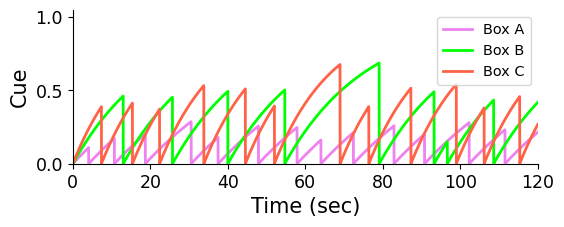

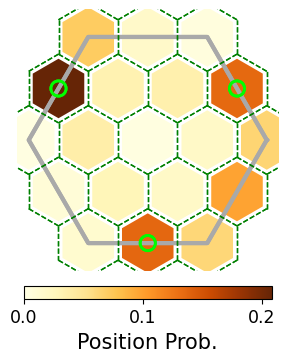

In [5]:
from hexarena.utils import align_monkey_data

block_data = align_monkey_data(load_monkey_data(filename, block_idx), block_idx)
env = SimilarBoxForagingEnv(
    box={
        '_target_': 'hexarena.box.StationaryBox', 'num_patches': 1, 'num_levels': 10, 'num_grades': 10,
    },
    boxes=[{'tau': tau, 'sigma': sigma} for tau, sigma in zip(block_data['taus'], block_data['kappas'])],
)

print([box.taus[0] for box in env.boxes])

fig, ax = plt.subplots(figsize=(6, 2))
colors = ['violet', 'lime', 'tomato']
for i, color in enumerate(colors):
    ax.plot(block_data['t'], block_data['cues'][:, i], color=color)
ax.legend(['Box A', 'Box B', 'Box C'], fontsize='x-small', loc='upper right')
ax.set_xlim([0, 120])
ax.set_xlabel('Time (sec)')
ax.set_ylim([0, 1.05])
ax.set_ylabel('Cue')

env_data = env.convert_experiment_data(block_data)
counts, _ = np.histogram(env_data['pos'], np.arange(-0.5, 0.5+env.arena.num_tiles))

fig, ax = plt.subplots(figsize=(4, 4))
env.arena.plot_mesh(ax)
env.arena.plot_map(ax, counts/counts.sum(), clabel='Position Prob.')

plt.show()